# Clustering with hierarchical trees

### Overview

  - [Grouping clusters in bottom-up fashion](#Grouping-clusters-in-bottom-up-fashion)
  - [Performing hierarchical clustering on a distance matrix](#Performing-hierarchical-clustering-on-a-distance-matrix)
  - [Attaching dendrograms to a heat map](#Attaching-dendrograms-to-a-heat-map)
  - [Applying agglomerative clustering via scikit-learn](#Applying-agglomerative-clustering-via-scikit-learn)

## Grouping clusters in bottom-up fashion

In [3]:
import pandas as pd
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

np.random.seed(123)

variables = ['X', 'Y', 'Z']
labels = ['ID_0', 'ID_1', 'ID_2', 'ID_3', 'ID_4']

X = np.random.random_sample([5, 3])*10
df = pd.DataFrame(X, columns=variables, index=labels)
df

,X,Y,Z
ID_0,6.964692,2.861393,2.268515
ID_1,5.513148,7.194690,4.231065
ID_2,9.807642,6.848297,4.809319
ID_3,3.921175,3.431780,7.290497
ID_4,4.385722,0.596779,3.980443


<br>

## Performing hierarchical clustering unsing scipy on a distance matrix

https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html


In [4]:
from scipy.spatial.distance import pdist, squareform

row_dist = pd.DataFrame(squareform(pdist(df, metric='euclidean')),
                        columns=labels,
                        index=labels)
row_dist

,ID_0,ID_1,ID_2,ID_3,ID_4
ID_0,0.000000,4.973534,5.516653,5.899885,3.835396
ID_1,4.973534,0.000000,4.347073,5.104311,6.698233
ID_2,5.516653,4.347073,0.000000,7.244262,8.316594
ID_3,5.899885,5.104311,7.244262,0.000000,4.382864
ID_4,3.835396,6.698233,8.316594,4.382864,0.000000


We can either pass a condensed distance matrix (upper triangular) from the `pdist` function, or we can pass the "original" data array and define the `metric='euclidean'` argument in `linkage`. However, we should not pass the squareform distance matrix, which would yield different distance values although the overall clustering could be the same.

In [5]:
# 1. incorrect approach: Squareform distance matrix

from scipy.cluster.hierarchy import linkage

row_clusters = linkage(row_dist, method='complete', metric='euclidean')
pd.DataFrame(row_clusters,
             columns=['row label 1', 'row label 2',
                      'distance', 'no. of items in clust.'],
             index=['cluster %d' % (i + 1)
                    for i in range(row_clusters.shape[0])])

,row label 1,row label 2,distance,no. of items in clust.
cluster 1,0.0,4.0,6.521973,2.0
cluster 2,1.0,2.0,6.729603,2.0
cluster 3,3.0,5.0,8.539247,3.0
cluster 4,6.0,7.0,12.444824,5.0


In [6]:
# 2. correct approach: Condensed distance matrix

row_clusters = linkage(pdist(df, metric='euclidean'), method='complete')
pd.DataFrame(row_clusters,
             columns=['row label 1', 'row label 2',
                      'distance', 'no. of items in clust.'],
             index=['cluster %d' % (i + 1) 
                    for i in range(row_clusters.shape[0])])

,row label 1,row label 2,distance,no. of items in clust.
cluster 1,0.0,4.0,3.835396,2.0
cluster 2,1.0,2.0,4.347073,2.0
cluster 3,3.0,5.0,5.899885,3.0
cluster 4,6.0,7.0,8.316594,5.0


In [7]:
# 3. correct approach: Input sample matrix

row_clusters = linkage(df.values, method='complete', metric='euclidean')
pd.DataFrame(row_clusters,
             columns=['row label 1', 'row label 2',
                      'distance', 'no. of items in clust.'],
             index=['cluster %d' % (i + 1)
                    for i in range(row_clusters.shape[0])])

,row label 1,row label 2,distance,no. of items in clust.
cluster 1,0.0,4.0,3.835396,2.0
cluster 2,1.0,2.0,4.347073,2.0
cluster 3,3.0,5.0,5.899885,3.0
cluster 4,6.0,7.0,8.316594,5.0


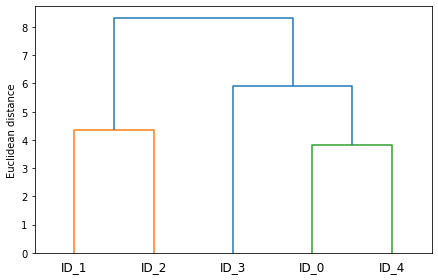

In [8]:
from scipy.cluster.hierarchy import dendrogram


# make dendrogram black (part 1/2)
# from scipy.cluster.hierarchy import set_link_color_palette
# set_link_color_palette(['black'])

row_dendr = dendrogram(row_clusters,
                       labels=labels,
                       # make dendrogram black (part 2/2)
                       # color_threshold=np.inf
                       )
plt.tight_layout()
plt.ylabel('Euclidean distance')
# plt.savefig('images/11_11.png', dpi=300,
#            bbox_inches='tight')
plt.show()

<br>

## Attaching dendrograms to a heat map

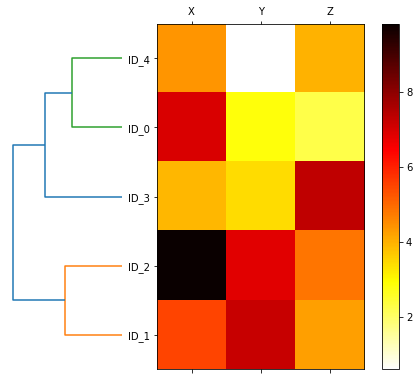

In [9]:
# plot row dendrogram
fig = plt.figure(figsize=(8, 8), facecolor='white')
axd = fig.add_axes([0.09, 0.1, 0.2, 0.6])

# note: for matplotlib < v1.5.1, please use orientation='right'
row_dendr = dendrogram(row_clusters, orientation='left')

# reorder data with respect to clustering
df_rowclust = df.iloc[row_dendr['leaves'][::-1]]

axd.set_xticks([])
axd.set_yticks([])

# remove axes spines from dendrogram
for i in axd.spines.values():
    i.set_visible(False)

# plot heatmap
axm = fig.add_axes([0.23, 0.1, 0.6, 0.6])  # x-pos, y-pos, width, height
cax = axm.matshow(df_rowclust, interpolation='nearest', cmap='hot_r')
fig.colorbar(cax)
axm.set_xticklabels([''] + list(df_rowclust.columns))
axm.set_yticklabels([''] + list(df_rowclust.index))

#plt.savefig('images/11_12.png', dpi=300)
plt.show()

## Applying agglomerative clustering via scikit-learn

http://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html


In [10]:
from sklearn.cluster import AgglomerativeClustering

ac = AgglomerativeClustering(n_clusters=3, 
                             affinity='euclidean', 
                             linkage='complete')
labels = ac.fit_predict(X)
print('Cluster labels: %s' % labels)

Cluster labels: [1 0 0 2 1]


In [11]:
ac = AgglomerativeClustering(n_clusters=2, 
                             affinity='euclidean', 
                             linkage='complete')
labels = ac.fit_predict(X)
print('Cluster labels: %s' % labels)

Cluster labels: [0 1 1 0 0]


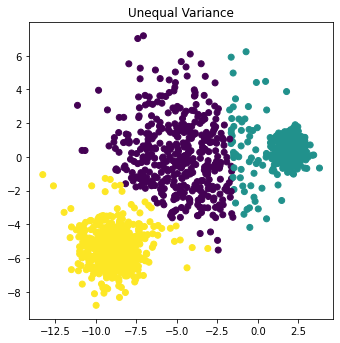

In [12]:
random_state = 170
n_samples=1500
plt.figure(figsize=(12, 12))
# Different variance
X_varied, y_varied = make_blobs(n_samples=n_samples,
                                cluster_std=[1.0, 2.5, 0.5],
                                random_state=random_state)
y_pred = KMeans(n_clusters=3, random_state=random_state).fit_predict(X_varied)

plt.subplot(223)
plt.scatter(X_varied[:, 0], X_varied[:, 1], c=y_pred)
plt.title("Unequal Variance")
plt.show()

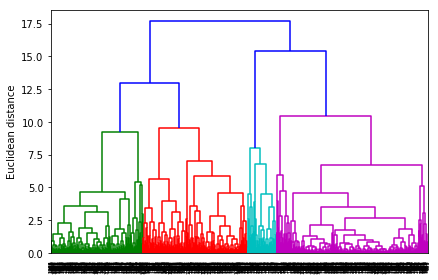

In [11]:
row_clusters = linkage(X_varied, method='complete', metric='euclidean')
row_dendr = dendrogram(row_clusters
                       # make dendrogram black (part 2/2)
                       # color_threshold=np.inf
                       )
plt.tight_layout()
plt.ylabel('Euclidean distance')
# plt.savefig('images/11_11.png', dpi=300,
#            bbox_inches='tight')
plt.show()

<br>

Cluster labels: [2 2 0 ... 1 1 1]


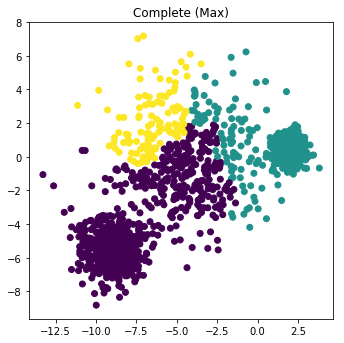

In [12]:
ac = AgglomerativeClustering(n_clusters=3, 
                             affinity='euclidean', 
                             linkage='complete')
labels = ac.fit_predict(X_varied)
print('Cluster labels: %s' % labels)

plt.figure(figsize=(12, 12))
# Different variance
plt.subplot(223)
plt.scatter(X_varied[:, 0], X_varied[:, 1], c=labels)
plt.title("Complete (Max)")
plt.show()

Cluster labels: [0 0 0 ... 0 0 0]


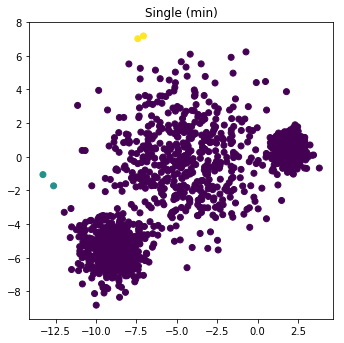

In [13]:
ac = AgglomerativeClustering(n_clusters=3, 
                             affinity='euclidean', 
                             linkage='single')
labels = ac.fit_predict(X_varied)
print('Cluster labels: %s' % labels)

plt.figure(figsize=(12, 12))
# Different variance
plt.subplot(223)
plt.scatter(X_varied[:, 0], X_varied[:, 1], c=labels)
plt.title("Single (min)")
plt.show()

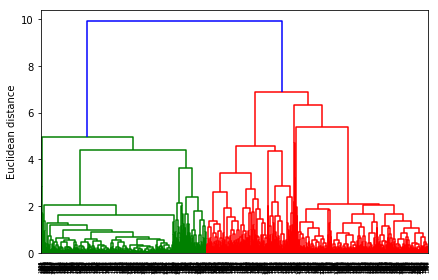

In [14]:
row_clusters = linkage(X_varied, method='average', metric='euclidean')
row_dendr = dendrogram(row_clusters
                       # make dendrogram black (part 2/2)
                       # color_threshold=np.inf
                       )
plt.tight_layout()
plt.ylabel('Euclidean distance')
# plt.savefig('images/11_11.png', dpi=300,
#            bbox_inches='tight')
plt.show()

Cluster labels: [2 2 0 ... 1 1 1]


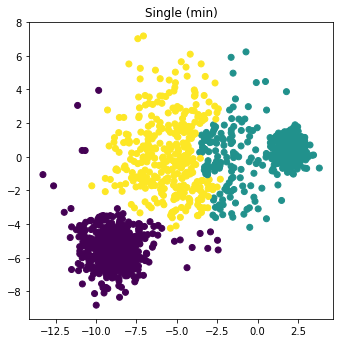

In [15]:
ac = AgglomerativeClustering(n_clusters=3, 
                             affinity='euclidean', 
                             linkage='average')
labels = ac.fit_predict(X_varied)
print('Cluster labels: %s' % labels)

plt.figure(figsize=(12, 12))
# Different variance
plt.subplot(223)
plt.scatter(X_varied[:, 0], X_varied[:, 1], c=labels)
plt.title("Single (min)")
plt.show()

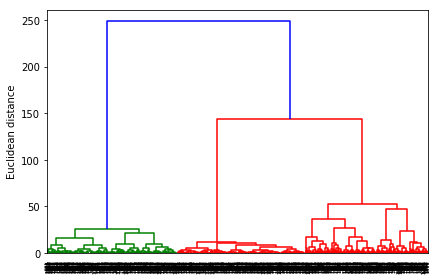

In [16]:
row_clusters = linkage(X_varied, method='ward', metric='euclidean')
row_dendr = dendrogram(row_clusters
                       # make dendrogram black (part 2/2)
                       # color_threshold=np.inf
                       )
plt.tight_layout()
plt.ylabel('Euclidean distance')
# plt.savefig('images/11_11.png', dpi=300,
#            bbox_inches='tight')
plt.show()

Cluster labels: [0 0 1 ... 2 2 2]


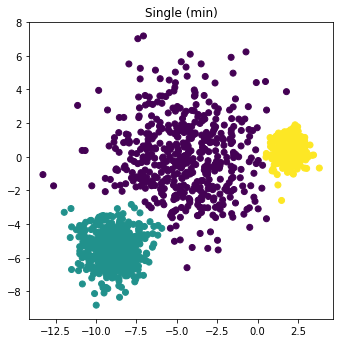

In [17]:
ac = AgglomerativeClustering(n_clusters=3, 
                             affinity='euclidean', 
                             linkage='ward')
labels = ac.fit_predict(X_varied)
print('Cluster labels: %s' % labels)

plt.figure(figsize=(12, 12))
# Different variance
plt.subplot(223)
plt.scatter(X_varied[:, 0], X_varied[:, 1], c=labels)
plt.title("Single (min)")
plt.show()

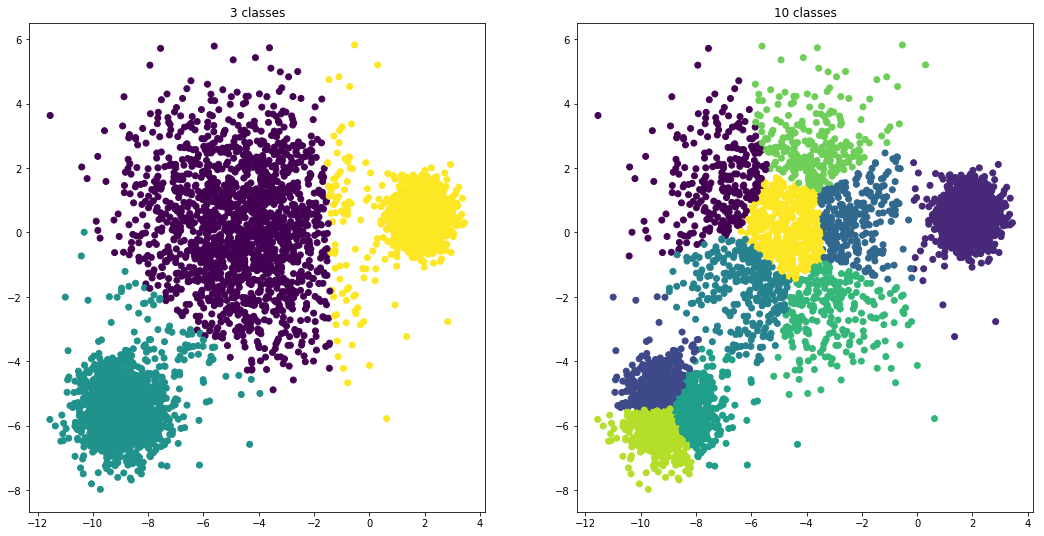

array([[-4.69057728,  0.18295097],
       [-8.86825853, -5.41487001],
       [ 1.77479501,  0.48094458]])

In [18]:
n_samples=5500
plt.figure(figsize=(18,9))
# Different variance
X_varied, y_varied = make_blobs(n_samples=n_samples,
                                cluster_std=[0.75, 2, 0.5],
                                random_state=random_state)

plt.subplot(121)
clf = KMeans(n_clusters=3, random_state=random_state, n_init=10)
clf.fit(X_varied)
y_pred = clf.predict(X_varied)
plt.scatter(X_varied[:, 0], X_varied[:, 1], c=y_pred)
plt.title("3 classes")

clfk = KMeans(n_clusters=10, random_state=random_state, n_init=10)
clfk.fit(X_varied)
y_predk = clfk.predict(X_varied)

plt.subplot(122)
plt.scatter(X_varied[:, 0], X_varied[:, 1], c=y_predk)
plt.title("10 classes")
plt.show()
clf.cluster_centers_

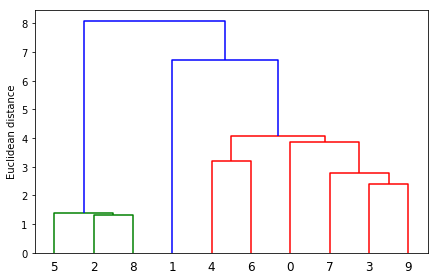

array([[-7.17073403,  1.61079463],
       [ 1.89999011,  0.49555014],
       [-9.29983181, -4.81345933],
       [-2.2883251 ,  0.34697864],
       [-6.23370109, -1.77002959],
       [-8.06849227, -5.49500546],
       [-3.12318679, -2.47654823],
       [-3.70614481,  2.76834767],
       [-9.31828842, -6.12348403],
       [-4.66778132,  0.17295969]])

In [19]:
row_clusters = linkage(clfk.cluster_centers_, method='average', metric='euclidean')
row_dendr = dendrogram(row_clusters
                       # make dendrogram black (part 2/2)
                       # color_threshold=np.inf
                       )
plt.tight_layout()
plt.ylabel('Euclidean distance')
# plt.savefig('images/11_11.png', dpi=300,
#            bbox_inches='tight')
plt.show()

clfk.cluster_centers_

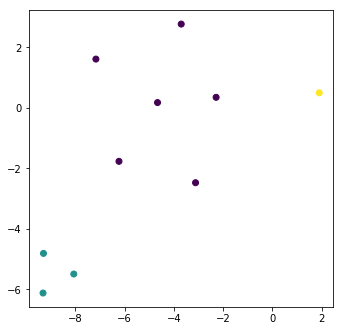

In [20]:
ac = AgglomerativeClustering(n_clusters=3, 
                             affinity='euclidean', 
                             linkage='average')
labels = ac.fit_predict(clfk.cluster_centers_)

plt.figure(figsize=(12, 12))
plt.subplot(223)
plt.scatter(clfk.cluster_centers_[:, 0], clfk.cluster_centers_[:, 1], c=labels)

plt.show()


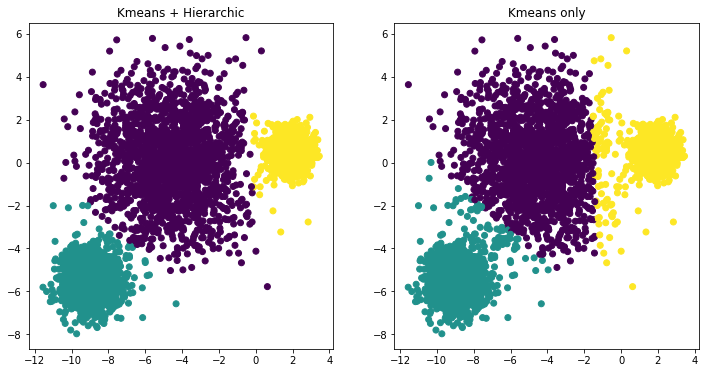

In [21]:
plt.figure(figsize=(12, 6))

plt.subplot(121)
lab1 = clfk.predict(X_varied)
labels = [labels[x] for x in lab1]
plt.scatter(X_varied[:, 0], X_varied[:, 1], c=labels)
plt.title("Kmeans + Hierarchic")

plt.subplot(122)
clf = KMeans(n_clusters=3, random_state=random_state, n_init=10)
clf.fit(X_varied)
y_pred = clf.predict(X_varied)
plt.scatter(X_varied[:, 0], X_varied[:, 1], c=y_pred)
plt.title("Kmeans only")


plt.show()



# DBSCAN = Isolating regions of high density 

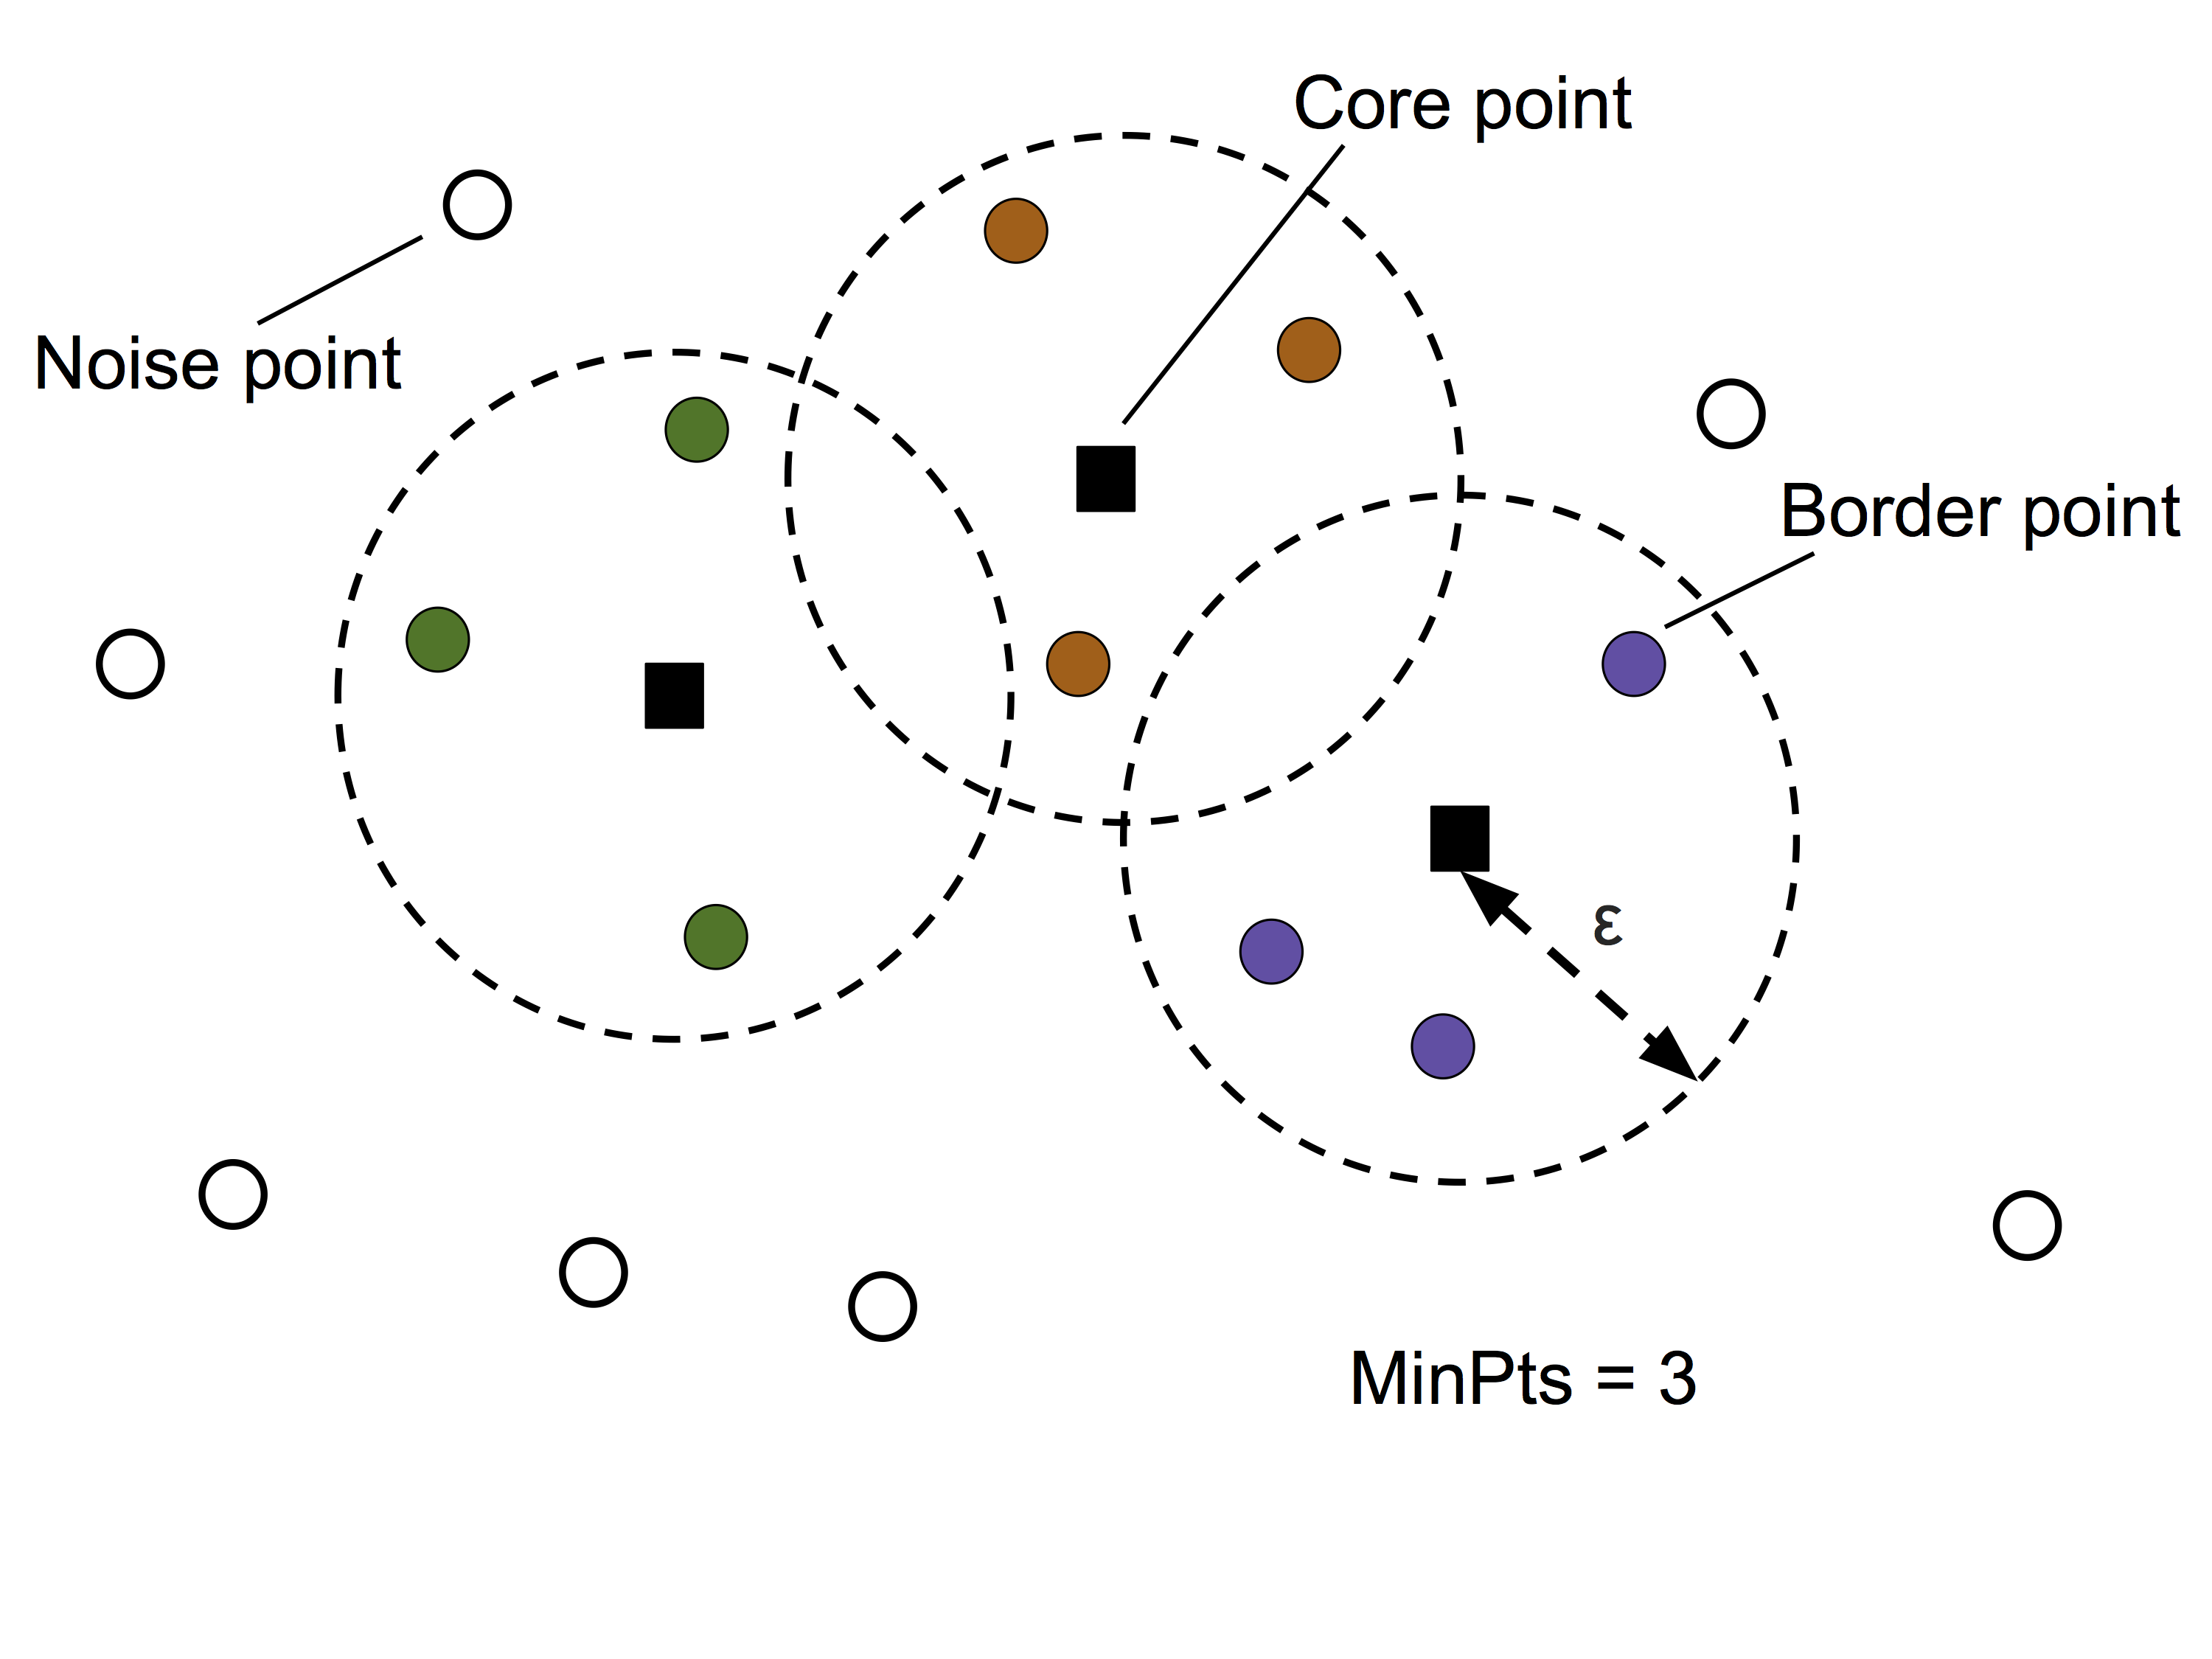

In [22]:
from IPython.display import Image
import matplotlib.pyplot as plt

%matplotlib inline
Image(filename='DBScan.png', width=500) 

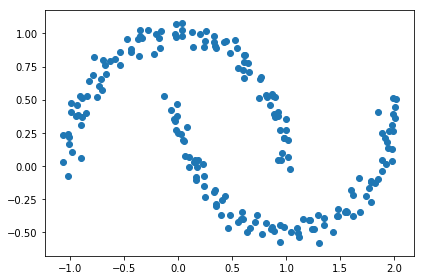

In [23]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=200, noise=0.05, random_state=0)
plt.scatter(X[:, 0], X[:, 1])
plt.tight_layout()
#plt.savefig('images/11_14.png', dpi=300)
plt.show()

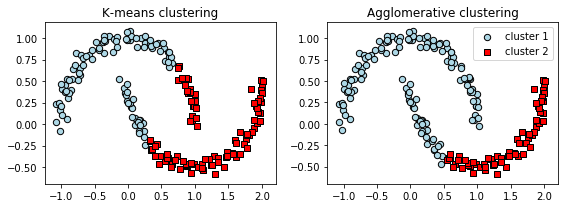

In [24]:
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

km = KMeans(n_clusters=2, random_state=0)
y_km = km.fit_predict(X)
ax1.scatter(X[y_km == 0, 0], X[y_km == 0, 1],
            edgecolor='black',
            c='lightblue', marker='o', s=40, label='cluster 1')
ax1.scatter(X[y_km == 1, 0], X[y_km == 1, 1],
            edgecolor='black',
            c='red', marker='s', s=40, label='cluster 2')
ax1.set_title('K-means clustering')

ac = AgglomerativeClustering(n_clusters=2,
                             affinity='euclidean',
                             linkage='ward')
y_ac = ac.fit_predict(X)
ax2.scatter(X[y_ac == 0, 0], X[y_ac == 0, 1], c='lightblue',
            edgecolor='black',
            marker='o', s=40, label='cluster 1')
ax2.scatter(X[y_ac == 1, 0], X[y_ac == 1, 1], c='red',
            edgecolor='black',
            marker='s', s=40, label='cluster 2')
ax2.set_title('Agglomerative clustering')

plt.legend()
plt.tight_layout()
# plt.savefig('images/11_15.png', dpi=300)
plt.show()

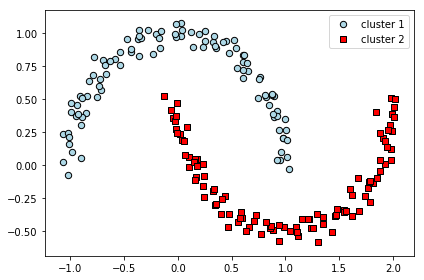

In [25]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.2, min_samples=5, metric='euclidean')
y_db = db.fit_predict(X)
plt.scatter(X[y_db == 0, 0], X[y_db == 0, 1],
            c='lightblue', marker='o', s=40,
            edgecolor='black', 
            label='cluster 1')
plt.scatter(X[y_db == 1, 0], X[y_db == 1, 1],
            c='red', marker='s', s=40,
            edgecolor='black', 
            label='cluster 2')
plt.legend()
plt.tight_layout()
#plt.savefig('images/11_16.png', dpi=300)
plt.show()

## We have to find the rigth parameters for DBScan

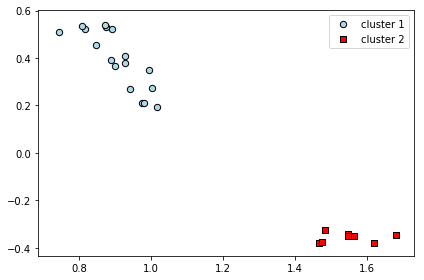

array([ 0,  1,  2, -1,  3,  3,  0,  4,  0, 14,  8,  9,  3,  5, 12,  0,  6,
       13,  7, -1, -1,  4,  7,  5,  8,  9,  3, -1,  9, -1,  0, -1,  4,  2,
       -1, 10, 13, 20, 17,  2, 11,  8,  6,  9,  1,  8,  0, 12,  9,  4, 19,
       13, -1, -1, 14, -1,  6,  5,  7,  8, 13, 15,  3,  0, 14, 15, -1,  1,
       16, 17, 11, 17, -1, -1,  4, 17,  2,  0,  6, -1, 10, 16, -1, 18,  2,
        8, 20,  8, 11, 10,  7,  0, 10, 19, 10,  3,  3, 13, 15,  9, -1, 10,
       16, 20, 17,  2, 15,  8,  1,  7, 19, 16, 16, 17,  0,  5,  6, 10, 11,
        0,  0, 12,  2, 16,  2, 12, 20,  9,  5, 18,  0, 19, 17,  9,  5, -1,
        5, 15, 18,  0,  9,  2,  7,  8,  8, 20,  9,  5,  7,  2, 11,  1,  0,
        7, 11, -1,  5, 13,  6,  6,  9, 14,  6,  1, 13, -1,  6, -1,  1, -1,
        6, -1, 17, 12,  9,  4, -1, 12, 12,  6,  1, 17, 10, -1, 10,  7, -1,
        4, 17, 19, 17,  7,  0,  0,  2, 19, 10,  9, 16, -1], dtype=int64)

In [26]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.1, min_samples=5, metric='euclidean')
y_db = db.fit_predict(X)
plt.scatter(X[y_db == 0, 0], X[y_db == 0, 1],
            c='lightblue', marker='o', s=40,
            edgecolor='black', 
            label='cluster 1')
plt.scatter(X[y_db == 1, 0], X[y_db == 1, 1],
            c='red', marker='s', s=40,
            edgecolor='black', 
            label='cluster 2')
plt.legend()
plt.tight_layout()
#plt.savefig('images/11_16.png', dpi=300)
plt.show()
y_db

## Finding parameters in DBScan

In [27]:
import numpy as np

from sklearn.metrics.pairwise import pairwise_distances
from scipy.spatial.distance import pdist, squareform

distances=squareform(pdist(X))

kcloser = 3
lkthc = [np.sort(x)[kcloser+1] for x in distances]

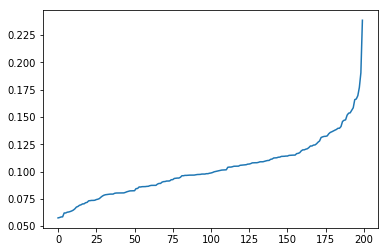

In [28]:
plt.plot(np.sort(lkthc))
plt.show()

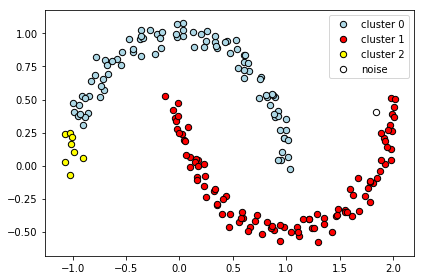

array([ 0,  1,  1,  2,  1,  1,  0,  1,  0,  1,  0,  1,  1,  1,  0,  0,  0,
        1,  0,  0,  1,  1,  0,  1,  0,  1,  1,  1,  1,  0,  0,  0,  1,  1,
        0,  1,  1,  0,  0,  1,  1,  0,  0,  1,  1,  0,  0,  0,  1,  1,  0,
        1,  1,  2,  1,  0,  0,  1,  0,  0,  1,  2,  1,  0,  1,  2,  0,  1,
        0,  0,  1,  0,  1,  1,  1,  0,  1,  0,  0,  1,  1,  0,  1,  1,  1,
        0,  0,  0,  1,  1,  0,  0,  1,  0,  1,  1,  1,  1,  2,  1,  1,  1,
        0,  0,  0,  1,  2,  0,  1,  0,  0,  0,  0,  0,  0,  1,  0,  1,  1,
        0,  0,  0,  1,  0,  1,  0,  0,  1,  1,  1,  0,  0,  0,  1,  1,  1,
        1,  2,  1,  0,  1,  1,  0,  0,  0,  0,  1,  1,  0,  1,  1,  1,  0,
        0,  1,  0,  1,  1,  0,  0,  1,  1,  0,  1,  1,  1,  0,  1,  1,  1,
        0,  2,  0,  0,  1,  1, -1,  0,  0,  0,  1,  0,  1,  1,  1,  0,  0,
        1,  0,  0,  0,  0,  0,  0,  1,  0,  1,  1,  0,  1], dtype=int64)

In [29]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.135, min_samples=kcloser, metric='euclidean')
y_db = db.fit_predict(X)

lc = ['lightblue','red','yellow','green','black','brown','blue']

for i in range(max(y_db)+1):
    plt.scatter(X[y_db == i, 0], X[y_db == i, 1],
                c=lc[i], marker='o', s=40,
                edgecolor='black', 
                label='cluster '+str(i))
    
plt.scatter(X[y_db < 0, 0], X[y_db <0, 1],
                c='white', marker='o', s=40,
                edgecolor='black', 
                label='noise')

plt.legend()
plt.tight_layout()
#plt.savefig('images/11_16.png', dpi=300)
plt.show()
y_db

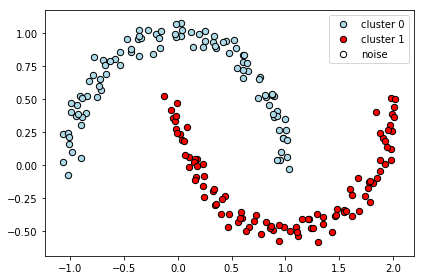

In [30]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.15, min_samples=kcloser, metric='euclidean')
y_db = db.fit_predict(X)

for i in range(max(y_db)+1):
    plt.scatter(X[y_db == i, 0], X[y_db == i, 1],
                c=lc[i], marker='o', s=40,
                edgecolor='black', 
                label='cluster '+str(i))
    
plt.scatter(X[y_db < 0, 0], X[y_db <0, 1],
                c='white', marker='o', s=40,
                edgecolor='black', 
                label='noise')
plt.legend()
plt.tight_layout()
#plt.savefig('images/11_16.png', dpi=300)
plt.show()

In [31]:
y_db

array([0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1], dtype=int64)

# Activitat 1 / Activity 1

Apliqueu els algorismes jerarquic i DBScan al conjunt de dades de borsa i avalueu-los.

1. Apliqueu els diferents algorismes jerarquics que coneixeu sobre el conjunt de dades i avalueu els resultats
2. Apliqueu els algorismes jerarquics sobre els centres de K-means amb k elevada (p.e. k=20) i avalueu-los
3. Mireu quins serien bons parametres per DBScan, apliqueu al conjunt de dades i avalueu resultats
4. Compareu els resultats de tots els mètodes i digueu quin mètode dona millors resultats i si creieu que hi ha algun motiu per això 

----------------------------

Apply the hierarchical algorithms and DBScan algorithm to the stocks data set and evaluate them.

1. Apply the different hierarchical algorithms you know about the dataset and evaluate the results
2. Apply the hierarchical algorithms on K-means centers with elevated k (p.e. k = 20) and evaluate them
3. Find good  parameters for DBScan, apply them to the data set and evaluate results
4. Compare the results of all the methods and show which method gives better results and if you think there is any reason for this
